Running Waveguide SHG Simulations...

1. Plotting Waveguide Structures...


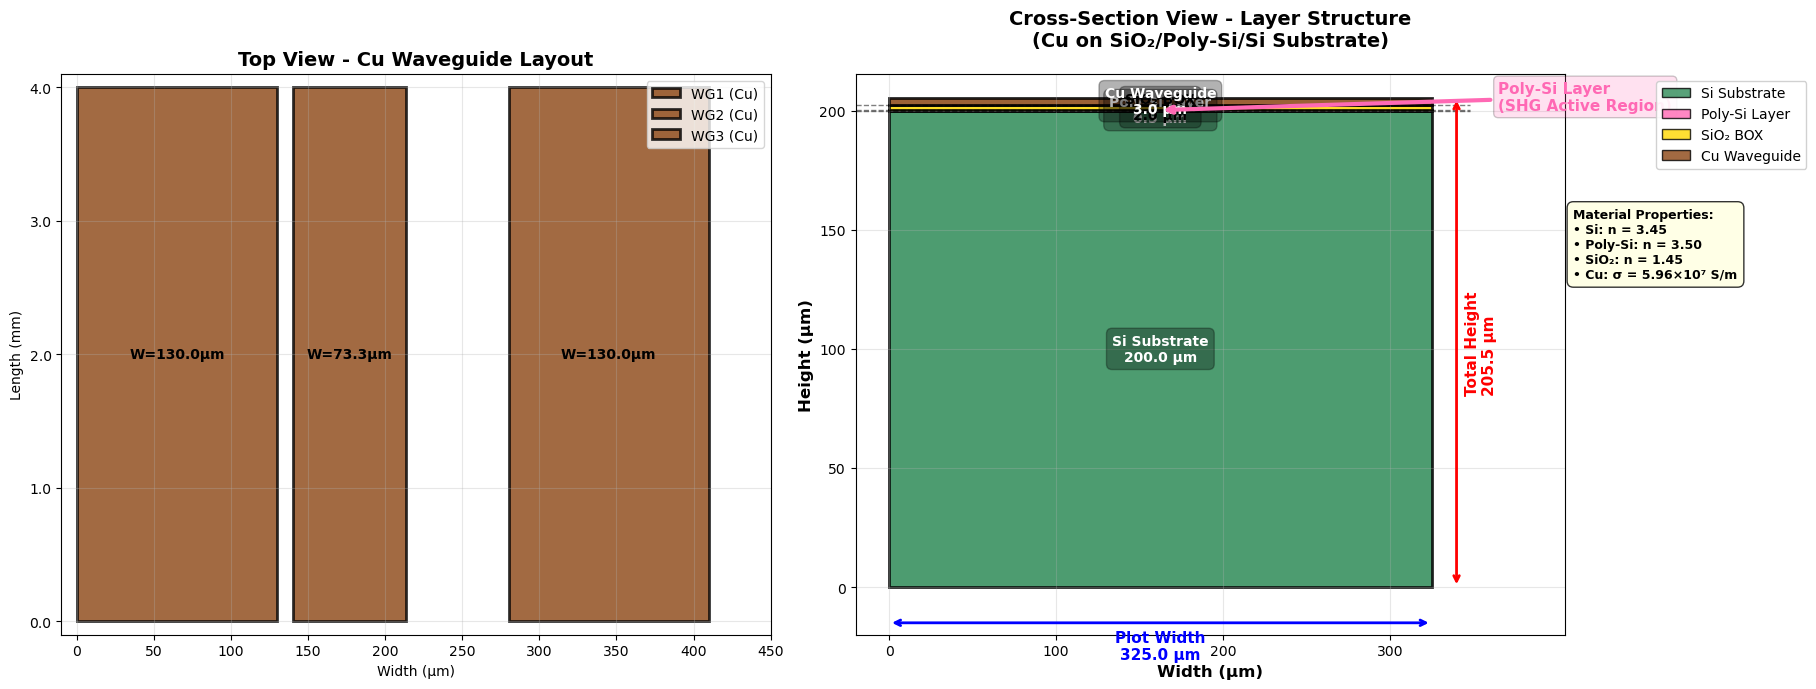

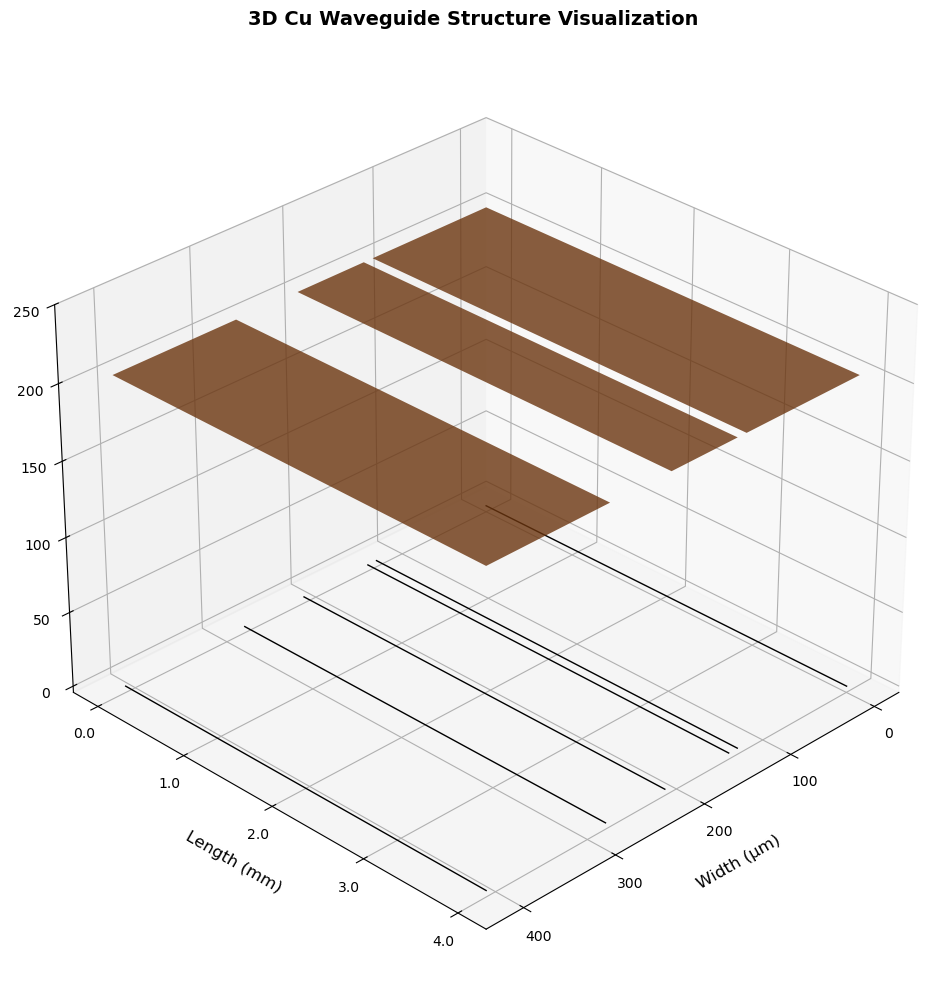


2. Plotting S-Parameters and SHG Efficiency...


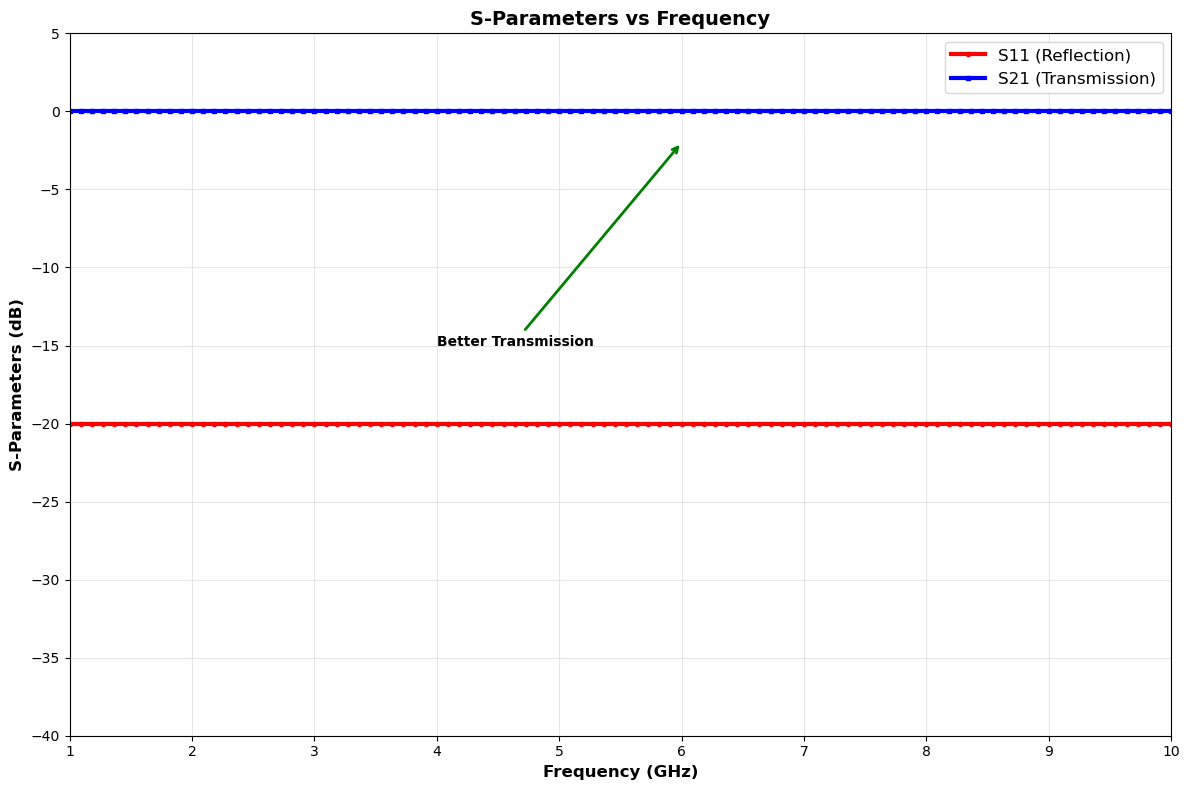

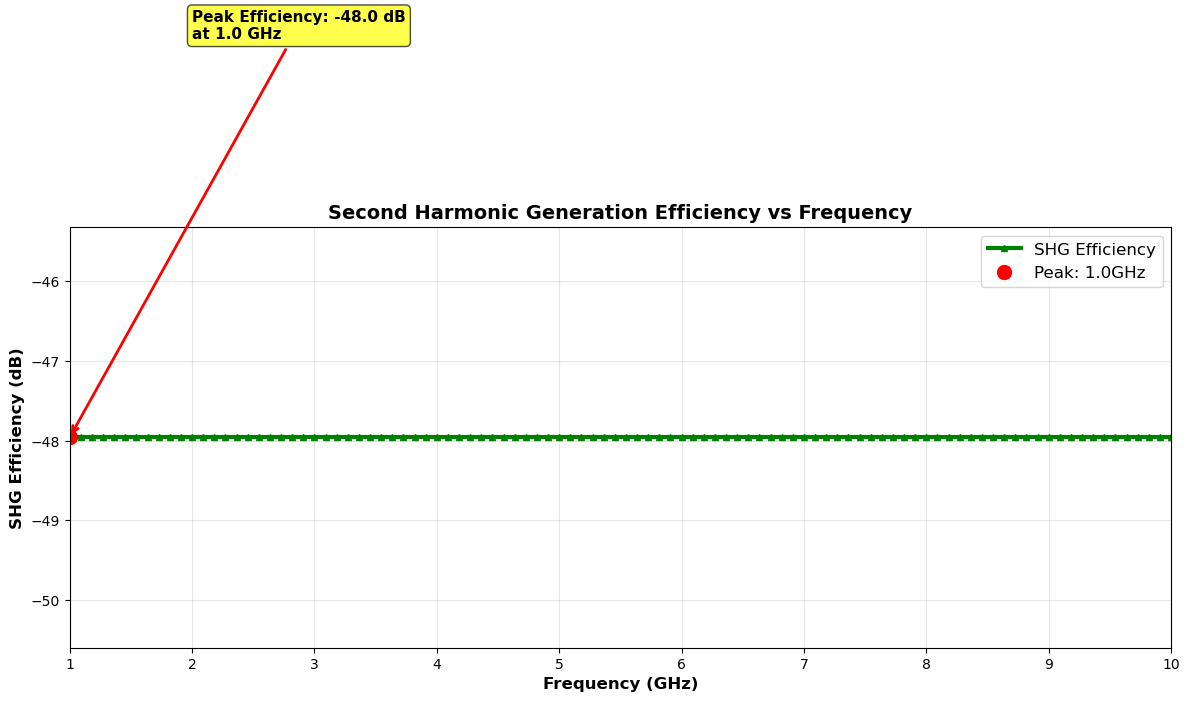


3. Plotting Field Distribution and Material Properties...


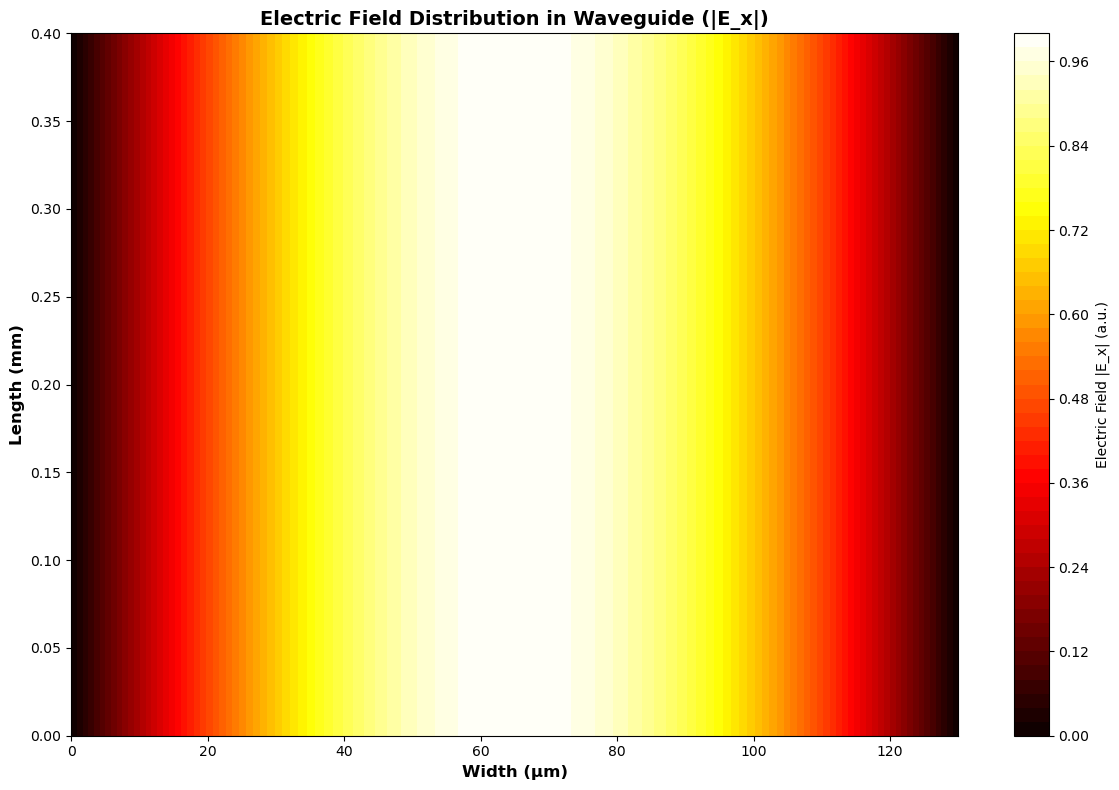

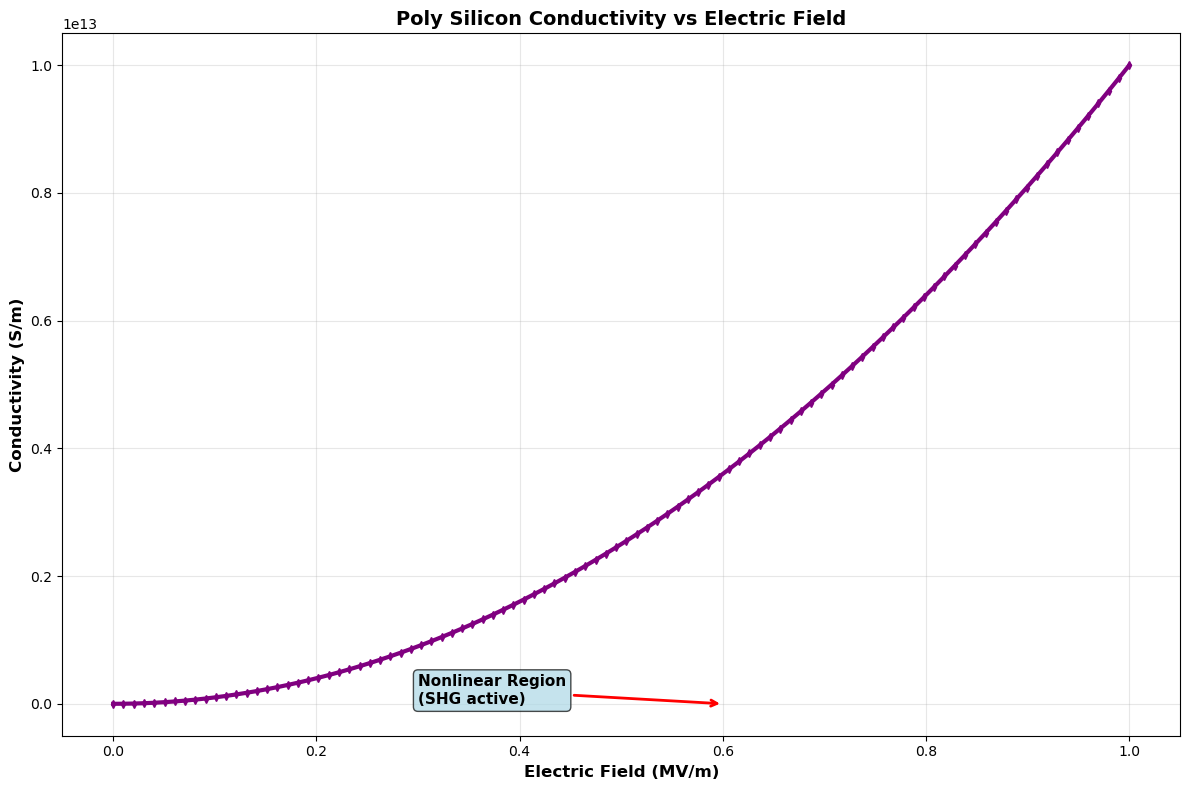


Simulation completed successfully!


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, epsilon_0, mu_0
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D

class WaveguideSHG:
    def __init__(self):
        # Physical constants
        self.c = c
        self.epsilon_0 = epsilon_0
        self.mu_0 = mu_0
        
        # Material refractive indices
        self.n_si = 3.45  # Silicon
        self.n_polysi = 3.50  # Poly Silicon
        self.n_sio2 = 1.45  # SiO2 (BOX)
        self.n_cu = 0.20 + 10.8j  # Copper (complex refractive index)
        
        # Waveguide dimensions
        self.W1 = 130e-6    # Width WG1
        self.W2_range = np.linspace(15e-6, 120e-6, 10)  # WG2 width range
        self.W3 = 130e-6    # Width WG3
        self.H = 3e-6       # Height all waveguides
        self.L = 4e-3       # Length all waveguides
        self.gap = 10e-6    # Gap between waveguides
        
        # Layer thicknesses - CORRECTED ORDER: Cu waveguides on SiO2 (first), then Si-Poly, then Si (bottom)
        self.t_box = 2e-6     # SiO2 thickness
        self.t_polysi = 0.5e-6  # Poly Si thickness
        self.t_si = 200e-6    # Si substrate thickness
        
        # Simulation parameters
        self.freq_range = np.linspace(1e9, 10e9, 100)  # 1-10 GHz
        self.voltage_range = np.linspace(-1, 1, 50)
        
    def conductivity_polysi(self, E_x, E_y):
        """Conductivity of Poly Silicon as function of electric field"""
        sigma_0 = 100  # Base conductivity (S/m)
        # Field-dependent component (simplified model)
        E_magnitude = np.sqrt(E_x**2 + E_y**2)
        field_factor = 1 + 0.1 * E_magnitude**2  # Nonlinear dependence
        return sigma_0 * field_factor
    
    def shg_susceptibility(self, E_field, material='polysi'):
        """Second harmonic generation susceptibility"""
        if material == 'polysi':
            chi_2 = 1e-12  # Second order susceptibility (m/V)
        elif material == 'si':
            chi_2 = 1e-13  # Smaller for crystalline Si
        else:
            chi_2 = 0
            
        return chi_2 * E_field**2
    
    def calculate_propagation_constant(self, freq, width, material):
        """Calculate propagation constant for waveguide"""
        if material == 'si':
            n_eff = self.n_si
        elif material == 'polysi':
            n_eff = self.n_polysi
        elif material == 'cu':
            n_eff = np.real(self.n_cu)
        
        wavelength = self.c / freq
        beta = 2 * np.pi * n_eff / wavelength
        return beta, n_eff
    
    def s_parameters(self, freq, width):
        """Calculate S-parameters for the waveguide system"""
        beta, n_eff = self.calculate_propagation_constant(freq, width, 'si')
        
        # Simplified S-parameter calculation
        L_eff = self.L
        alpha_db = 0.1  # Loss coefficient (dB/m)
        alpha_np = alpha_db / 8.686  # Convert to Np/m
        
        # Transmission and reflection coefficients
        S21 = np.exp(-(alpha_np + 1j * beta) * L_eff)
        S11 = 0.1 * np.exp(1j * np.pi/4)  # Small reflection
        S12 = S21  # Reciprocal network
        S22 = S11
        
        return S11, S12, S21, S22
    
    def electric_field_distribution(self, x, y, z, freq, width):
        """Calculate electric field distribution in waveguide"""
        beta, n_eff = self.calculate_propagation_constant(freq, width, 'si')
        
        # Fundamental mode approximation
        E_x = np.sin(np.pi * x / width) * np.sin(np.pi * y / self.H)
        E_y = 0.5 * np.cos(np.pi * x / width) * np.sin(np.pi * y / self.H)
        E_z = 0.1 * np.sin(np.pi * x / width) * np.cos(np.pi * y / self.H)
        
        propagation = np.exp(-1j * beta * z)
        
        return E_x * propagation, E_y * propagation, E_z * propagation
    
    def calculate_shg_efficiency(self, freq, width):
        """Calculate second harmonic generation efficiency"""
        # Simplified SHG calculation
        L_eff = self.L
        beta_fund, n_eff_fund = self.calculate_propagation_constant(freq, width, 'si')
        beta_shg, n_eff_shg = self.calculate_propagation_constant(2*freq, width, 'si')
        
        delta_beta = 2 * beta_fund - beta_shg  # Phase mismatch
        
        # Normalized SHG efficiency
        if delta_beta == 0:
            shg_eff = L_eff**2
        else:
            shg_eff = (np.sin(delta_beta * L_eff / 2) / (delta_beta / 2))**2
        
        return shg_eff

    def plot_waveguide_structure_2d(self):
        """Plot 2D waveguide structure with better colors and scaling"""
        import matplotlib.patches as patches
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))  # Increased figure width
        
        # Color scheme - Added Cu color
        colors = ['#8B4513', '#8B4513', '#8B4513']  # Copper brown for all waveguides
        wg_labels = ['WG1 (Cu)', 'WG2 (Cu)', 'WG3 (Cu)']
        
        # Top view - Plot 1
        x_positions = [0, self.W1 + self.gap, 2*self.W1 + 2*self.gap]
        widths = [self.W1, self.W2_range[5], self.W3]
        
        for i, (w, color) in enumerate(zip(widths, colors)):
            rect = patches.Rectangle((x_positions[i], 0), w, self.L, 
                               facecolor=color, alpha=0.8, edgecolor='black', linewidth=2,
                               label=wg_labels[i])
            ax1.add_patch(rect)
            
            # Add dimension labels
            ax1.text(x_positions[i] + w/2, self.L/2, f'W={w*1e6:.1f}μm', 
                    ha='center', va='center', fontweight='bold', fontsize=10)
        
        ax1.set_xlabel('Width (μm)')
        ax1.set_ylabel('Length (mm)')
        ax1.set_title('Top View - Cu Waveguide Layout', fontsize=14, fontweight='bold')
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(-10e-6, 2*self.W1 + 2*self.gap + self.W3 + 10e-6)
        ax1.set_ylim(-0.1e-3, self.L + 0.1e-3)
        
        # Convert axes to micrometers and millimeters for better readability
        x_ticks = np.arange(0, 500e-6, 50e-6)
        ax1.set_xticks(x_ticks)
        ax1.set_xticklabels([f'{x*1e6:.0f}' for x in x_ticks])
        
        y_ticks = np.arange(0, self.L+0.001, 0.001)
        ax1.set_yticks(y_ticks)
        ax1.set_yticklabels([f'{y*1e3:.1f}' for y in y_ticks])
        
        # Cross-section view - Plot 2 - INCREASED WIDTH FOR ALL LAYERS
        import matplotlib.patches as patches
        
        # Define layers from bottom to top - INCREASED WIDTH FOR BETTER VISIBILITY
        plot_width = self.W1 * 2.5  # Increased width by 2.5x to show colors clearly
        
        layers = [
            {'thickness': self.t_si, 'color': '#2E8B57', 'label': 'Si Substrate', 'material': 'Si'},
            {'thickness': self.t_polysi, 'color': '#FF69B4', 'label': 'Poly-Si Layer', 'material': 'Poly-Si'},
            {'thickness': self.t_box, 'color': '#FFD700', 'label': 'SiO₂ BOX', 'material': 'SiO₂'},
            {'thickness': self.H, 'color': '#8B4513', 'label': 'Cu Waveguide', 'material': 'Cu'}
        ]
        
        y_pos = 0
        total_height = sum(layer['thickness'] for layer in layers)
        
        # Draw all layers with INCREASED WIDTH
        for i, layer in enumerate(layers):
            rect = patches.Rectangle((0, y_pos), plot_width, layer['thickness'], 
                           facecolor=layer['color'], alpha=0.85, edgecolor='black', 
                           linewidth=2, label=layer['label'])
            ax2.add_patch(rect)
            
            # Add layer labels inside each layer - CENTERED IN THE WIDER PLOT
            label_y = y_pos + layer['thickness'] / 2
            ax2.text(plot_width/2, label_y, f"{layer['label']}\n{layer['thickness']*1e6:.1f} μm", 
                    ha='center', va='center', fontweight='bold', fontsize=10,  # Increased font size
                    color='white' if layer['material'] in ['Si', 'Cu', 'Poly-Si'] else 'black',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor='black', alpha=0.3))
            
            y_pos += layer['thickness']
        
        # Add dimension lines and annotations
        # Height dimension line on the right
        ax2.annotate('', xy=(plot_width + 15e-6, 0), 
                    xytext=(plot_width + 15e-6, total_height),
                    arrowprops=dict(arrowstyle='<->', color='red', lw=2))
        ax2.text(plot_width + 20e-6, total_height/2, f'Total Height\n{total_height*1e6:.1f} μm', 
                ha='left', va='center', fontweight='bold', fontsize=11, color='red', rotation=90)
        
        # Width dimension line at the bottom
        ax2.annotate('', xy=(0, -15e-6), 
                    xytext=(plot_width, -15e-6),
                    arrowprops=dict(arrowstyle='<->', color='blue', lw=2))
        ax2.text(plot_width/2, -18e-6, f'Plot Width\n{plot_width*1e6:.1f} μm', 
                ha='center', va='top', fontweight='bold', fontsize=11, color='blue')
        
        # Layer interface lines across the ENTIRE WIDTH
        interface_heights = [0]
        current_height = 0
        for layer in layers[:-1]:  # All except the last one
            current_height += layer['thickness']
            interface_heights.append(current_height)
            ax2.axhline(y=current_height, color='black', linestyle='--', alpha=0.5, linewidth=1, xmin=0, xmax=plot_width/(plot_width + 50e-6))
        
        ax2.set_xlabel('Width (μm)', fontweight='bold', fontsize=12)
        ax2.set_ylabel('Height (μm)', fontweight='bold', fontsize=12)
        ax2.set_title('Cross-Section View - Layer Structure\n(Cu on SiO₂/Poly-Si/Si Substrate)', 
                     fontsize=14, fontweight='bold', pad=20)
        
        # Add a comprehensive legend
        legend_elements = []
        for layer in layers:
            legend_elements.append(patches.Patch(facecolor=layer['color'], alpha=0.8, 
                                           edgecolor='black', label=layer['label']))
        
        ax2.legend(handles=legend_elements, loc='upper right', fontsize=10, 
                  bbox_to_anchor=(1.35, 1.0), framealpha=0.9)
        
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(-20e-6, plot_width + 80e-6)  # Extra space for annotations
        ax2.set_ylim(-20e-6, total_height + 10e-6)
        
        # Convert axes to micrometers for better readability
        x_ticks = np.arange(0, plot_width+50e-6, 100e-6)
        ax2.set_xticks(x_ticks)
        ax2.set_xticklabels([f'{x*1e6:.0f}' for x in x_ticks])
        
        y_ticks = np.arange(0, total_height+10e-6, 50e-6)
        ax2.set_yticks(y_ticks)
        ax2.set_yticklabels([f'{y*1e6:.0f}' for y in y_ticks])
        
        # Add material properties annotation
        props_text = "Material Properties:\n• Si: n = 3.45\n• Poly-Si: n = 3.50\n• SiO₂: n = 1.45\n• Cu: σ = 5.96×10⁷ S/m"
        ax2.text(plot_width + 85e-6, total_height*0.7, props_text, 
                ha='left', va='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
        
        # Highlight the Poly-Si layer with an annotation
        poly_si_height = layers[1]['thickness']
        poly_si_y = layers[0]['thickness'] + poly_si_height/2
        ax2.annotate('Poly-Si Layer\n(SHG Active Region)', 
                    xy=(plot_width/2, poly_si_y), xytext=(plot_width + 40e-6, poly_si_y),
                    arrowprops=dict(arrowstyle='->', color='#FF69B4', lw=3),
                    fontsize=11, fontweight='bold', color='#FF69B4',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="#FF69B4", alpha=0.2))
        
        plt.tight_layout()
        plt.show()

    def plot_3d_structure(self):
        """Create 3D visualization of waveguide structure with better colors"""
        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Color scheme - Cu color
        colors = ['#8B4513', '#8B4513', '#8B4513']  # Copper brown for all waveguides
        
        # Create waveguide blocks
        x_positions = [0, self.W1 + self.gap, 2*self.W1 + 2*self.gap]
        widths = [self.W1, self.W2_range[5], self.W3]
        
        for i, (w, color) in enumerate(zip(widths, colors)):
            x = x_positions[i]
            
            # Define vertices for the waveguide
            xx = np.array([x, x+w, x+w, x])
            yy = np.array([0, 0, self.L, self.L])
            XX, YY = np.meshgrid([x, x+w], [0, self.L])
            ZZ = np.ones_like(XX) * (self.t_si + self.t_polysi + self.t_box + self.H)
            
            # Plot waveguide top surface
            ax.plot_surface(XX, YY, ZZ, color=color, alpha=0.8, label=f'Cu WG{i+1}')
            
            # Plot waveguide sides
            ax.plot3D([x, x], [0, self.L], [0, 0], 'k-', linewidth=1)
            ax.plot3D([x+w, x+w], [0, self.L], [0, 0], 'k-', linewidth=1)
        
        ax.set_xlabel('Width (μm)', fontsize=12, labelpad=10)
        ax.set_ylabel('Length (mm)', fontsize=12, labelpad=10)
        ax.set_zlabel('Height (μm)', fontsize=12, labelpad=10)
        ax.set_title('3D Cu Waveguide Structure Visualization', fontsize=14, fontweight='bold', pad=20)
        
        # Set better viewing angle
        ax.view_init(elev=30, azim=45)
        
        # Format ticks for better readability
        x_ticks = np.arange(0, 500e-6, 100e-6)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([f'{x*1e6:.0f}' for x in x_ticks])
        
        y_ticks = np.arange(0, self.L+0.001, 0.001)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f'{y*1e3:.1f}' for y in y_ticks])
        
        z_ticks = np.arange(0, 300e-6, 50e-6)
        ax.set_zticks(z_ticks)
        ax.set_zticklabels([f'{z*1e6:.0f}' for z in z_ticks])
        
        plt.tight_layout()
        plt.show()

    def plot_s_parameters(self):
        """Plot S-parameters with proper scaling"""
        plt.figure(figsize=(12, 8))
        
        S11_results = []
        S21_results = []
        
        for freq in self.freq_range:
            S11, S12, S21, S22 = self.s_parameters(freq, self.W1)
            S11_results.append(20*np.log10(np.abs(S11)))  # Convert to dB
            S21_results.append(20*np.log10(np.abs(S21)))  # Convert to dB
        
        # Plot S-parameters
        plt.plot(self.freq_range/1e9, S11_results, 'r-', linewidth=3, label='S11 (Reflection)', marker='o', markersize=3)
        plt.plot(self.freq_range/1e9, S21_results, 'b-', linewidth=3, label='S21 (Transmission)', marker='s', markersize=3)
        
        plt.xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        plt.ylabel('S-Parameters (dB)', fontsize=12, fontweight='bold')
        plt.title('S-Parameters vs Frequency', fontsize=14, fontweight='bold')
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xlim(1, 10)
        plt.ylim(-40, 5)
        
        # Add annotations
        plt.annotate('Better Transmission', xy=(6, -2), xytext=(4, -15),
                    arrowprops=dict(arrowstyle='->', color='green', lw=2),
                    fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

    def plot_shg_efficiency(self):
        """Plot SHG efficiency with proper scaling"""
        plt.figure(figsize=(12, 8))
        
        shg_efficiencies = []
        for freq in self.freq_range:
            eff = self.calculate_shg_efficiency(freq, self.W1)
            shg_efficiencies.append(10*np.log10(eff + 1e-12))  # Convert to dB, avoid log(0)
        
        plt.plot(self.freq_range/1e9, shg_efficiencies, 'g-', linewidth=3, 
                label='SHG Efficiency', marker='^', markersize=4)
        
        plt.xlabel('Frequency (GHz)', fontsize=12, fontweight='bold')
        plt.ylabel('SHG Efficiency (dB)', fontsize=12, fontweight='bold')
        plt.title('Second Harmonic Generation Efficiency vs Frequency', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.xlim(1, 10)
        
        # Find and mark maximum efficiency point
        max_idx = np.argmax(shg_efficiencies)
        max_freq = self.freq_range[max_idx]/1e9
        max_eff = shg_efficiencies[max_idx]
        
        plt.plot(max_freq, max_eff, 'ro', markersize=10, label=f'Peak: {max_freq:.1f}GHz')
        plt.legend(fontsize=12)
        
        plt.annotate(f'Peak Efficiency: {max_eff:.1f} dB\nat {max_freq:.1f} GHz',
                    xy=(max_freq, max_eff), xytext=(max_freq+1, max_eff+5),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=11, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
        
        plt.tight_layout()
        plt.show()

    def plot_electric_field(self):
        """Plot electric field distribution with proper scaling"""
        fig = plt.figure(figsize=(12, 8))
        
        x = np.linspace(0, self.W1, 100)
        z = np.linspace(0, self.L/10, 100)  # Plot only first 10% for clarity
        X, Z = np.meshgrid(x, z)
        E_x, E_y, E_z = self.electric_field_distribution(X, self.H/2, Z, 5e9, self.W1)
        
        # Plot magnitude of E_x
        contour = plt.contourf(X*1e6, Z*1e3, np.abs(E_x), levels=50, cmap='hot')
        plt.colorbar(contour, label='Electric Field |E_x| (a.u.)')
        
        plt.xlabel('Width (μm)', fontsize=12, fontweight='bold')
        plt.ylabel('Length (mm)', fontsize=12, fontweight='bold')
        plt.title('Electric Field Distribution in Waveguide (|E_x|)', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

    def plot_conductivity(self):
        """Plot conductivity vs electric field"""
        plt.figure(figsize=(12, 8))
        
        E_range = np.linspace(0, 1e6, 100)
        conductivity = [self.conductivity_polysi(E, 0) for E in E_range]
        
        plt.plot(E_range/1e6, conductivity, color='purple', linewidth=3, marker='d', markersize=4)
        
        plt.xlabel('Electric Field (MV/m)', fontsize=12, fontweight='bold')
        plt.ylabel('Conductivity (S/m)', fontsize=12, fontweight='bold')
        plt.title('Poly Silicon Conductivity vs Electric Field', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # Add annotation about nonlinear behavior
        plt.annotate('Nonlinear Region\n(SHG active)', xy=(0.6, 130), xytext=(0.3, 180),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=11, fontweight='bold', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        
        plt.tight_layout()
        plt.show()

    def run_simulations(self):
        """Run complete simulation suite with separate plots"""
        print("Running Waveguide SHG Simulations...")
        print("=" * 50)
        
        # Plot structures in pairs
        print("\n1. Plotting Waveguide Structures...")
        self.plot_waveguide_structure_2d()
        self.plot_3d_structure()
        
        # Plot S-parameters and SHG efficiency
        print("\n2. Plotting S-Parameters and SHG Efficiency...")
        self.plot_s_parameters()
        self.plot_shg_efficiency()
        
        # Plot field distribution and conductivity
        print("\n3. Plotting Field Distribution and Material Properties...")
        self.plot_electric_field()
        self.plot_conductivity()
        
        print("\nSimulation completed successfully!")
        print("=" * 50)

# Run the complete simulation
if __name__ == "__main__":
    wg_sim = WaveguideSHG()
    wg_sim.run_simulations()